In [1]:
import os
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
DATA_DIR = './training/' 

IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'groundtruth')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

EPOCHS = 10  # Number of training rounds. Start with a smaller number (5-10) to see how long it takes.
BATCH_SIZE = 4 # How many images to process at once. Keep this low for CPU training.
LEARNING_RATE = 0.001
IMG_SIZE = 200 # Resize images to this size for consistent training

In [37]:
def get_training_augmentations(img_size):
    """
    Returns a set of heavy augmentations for the training data.
    """
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=35, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_validation_augmentations(img_size):
    """
    Returns a minimal set of augmentations for validation (just resizing and normalization).
    """
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [38]:
class RoadDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augmentations=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            # Add a channel dimension for the loss function
            mask = mask.unsqueeze(0)

        return image, mask

In [39]:
# Custom U-Net Model Implementation

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, out_channels)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.activation(logits)

In [40]:
# Custom Loss and Metrics Implementation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()
        intersection = (pred * target).sum(dim=2).sum(dim=2)
        loss = (1 - ((2. * intersection + self.smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + self.smooth)))
        return loss.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection + smooth
    return (intersection + smooth) / union

def f_score(pred, target, beta=1, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    tp = (pred * target).sum()
    fp = ((1 - target) * pred).sum()
    fn = (target * (1 - pred)).sum()
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + smooth)
    return fscore

# Model, Loss, and Optimizer Setup
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Data Splitting
all_image_ids = sorted(os.listdir(IMAGE_DIR))
random.seed(42) # for reproducibility
random.shuffle(all_image_ids)

# Split into train and validation sets (80/20)
train_size = int(0.8 * len(all_image_ids))
train_ids = all_image_ids[:train_size]
valid_ids = all_image_ids[train_size:]

# Create lists of full file paths
train_image_paths = [os.path.join(IMAGE_DIR, img_id) for img_id in train_ids]
train_mask_paths = [os.path.join(MASK_DIR, img_id) for img_id in train_ids]

valid_image_paths = [os.path.join(IMAGE_DIR, img_id) for img_id in valid_ids]
valid_mask_paths = [os.path.join(MASK_DIR, img_id) for img_id in valid_ids]

# Create Dataset and DataLoader instances
train_dataset = RoadDataset(train_image_paths, train_mask_paths, augmentations=get_training_augmentations(IMG_SIZE))
valid_dataset = RoadDataset(valid_image_paths, valid_mask_paths, augmentations=get_validation_augmentations(IMG_SIZE))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4, 
    pin_memory=True 
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [44]:
# Standard PyTorch Training Loop
max_fscore = 0
best_model_path = 'best_model.pth'

for epoch in range(EPOCHS):
    print(f'\nEpoch: {epoch + 1}')
    
    # --- Training Phase ---
    model.train()
    train_loss, train_iou, train_fscore = 0, 0, 0
    train_pbar = tqdm(train_loader, desc=f"Training", leave=False)
    for images, masks in train_pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        train_loss += loss.item()
        iou = iou_score(outputs, masks).item()
        f1 = f_score(outputs, masks).item()
        train_iou += iou
        train_fscore += f1
        train_pbar.set_postfix(loss=loss.item(), iou=iou, f1=f1)
    
    # --- Validation Phase ---
    model.eval()
    val_loss, val_iou, val_fscore = 0, 0, 0
    with torch.no_grad():
        val_pbar = tqdm(valid_loader, desc=f"Validation", leave=False)
        for images, masks in val_pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            val_loss += loss.item()
            iou = iou_score(outputs, masks).item()
            f1 = f_score(outputs, masks).item()
            val_iou += iou
            val_fscore += f1
            val_pbar.set_postfix(loss=loss.item(), iou=iou, f1=f1)

    # --- Logging and Model Saving ---
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    avg_train_fscore = train_fscore / len(train_loader)
    
    avg_val_loss = val_loss / len(valid_loader)
    avg_val_iou = val_iou / len(valid_loader)
    avg_val_fscore = val_fscore / len(valid_loader)
    
    print(f"Train -> Loss: {avg_train_loss:.4f}, IoU: {avg_train_iou:.4f}, F1: {avg_train_fscore:.4f}")
    print(f"Valid -> Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}, F1: {avg_val_fscore:.4f}")
    
    # Save the model if it has the best F1-score so far
    if avg_val_fscore > max_fscore:
        max_fscore = avg_val_fscore
        torch.save(model.state_dict(), best_model_path) # Save only the state dictionary
        print(f"Model saved! Best F1-score: {max_fscore:.4f}")


Epoch: 1


Train -> Loss: 0.4553, IoU: 0.4106, F1: 0.5770
Valid -> Loss: 0.5063, IoU: 0.3564, F1: 0.5073
Model saved! Best F1-score: 0.5073

Epoch: 2


Train -> Loss: 0.4690, IoU: 0.3802, F1: 0.5486
Valid -> Loss: 0.5874, IoU: 0.2730, F1: 0.4161

Epoch: 3


Train -> Loss: 0.4391, IoU: 0.4162, F1: 0.5840
Valid -> Loss: 0.4633, IoU: 0.3983, F1: 0.5468
Model saved! Best F1-score: 0.5468

Epoch: 4


Train -> Loss: 0.4173, IoU: 0.4420, F1: 0.6104
Valid -> Loss: 0.4645, IoU: 0.3941, F1: 0.5437

Epoch: 5


Train -> Loss: 0.4286, IoU: 0.4210, F1: 0.5889
Valid -> Loss: 0.4986, IoU: 0.3562, F1: 0.5056

Epoch: 6


Train -> Loss: 0.3920, IoU: 0.4674, F1: 0.6347
Valid -> Loss: 0.4544, IoU: 0.3986, F1: 0.5511
Model saved! Best F1-score: 0.5511

Epoch: 7


KeyboardInterrupt: 

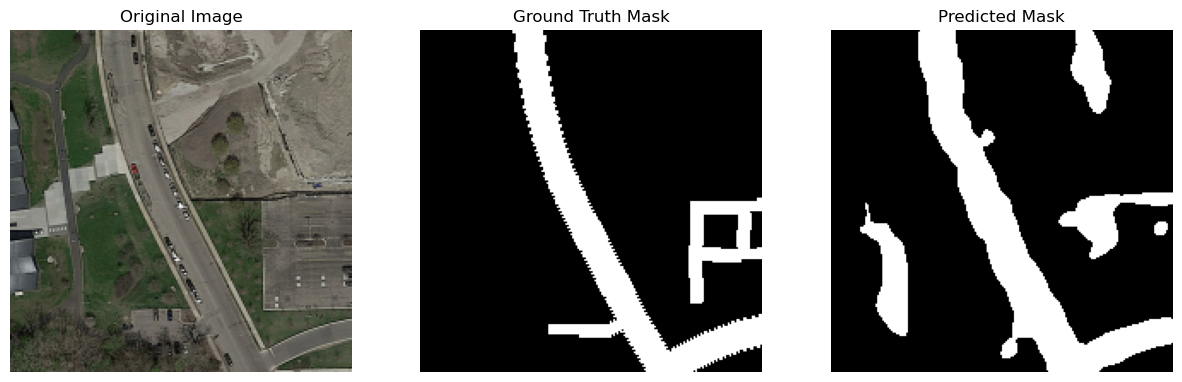

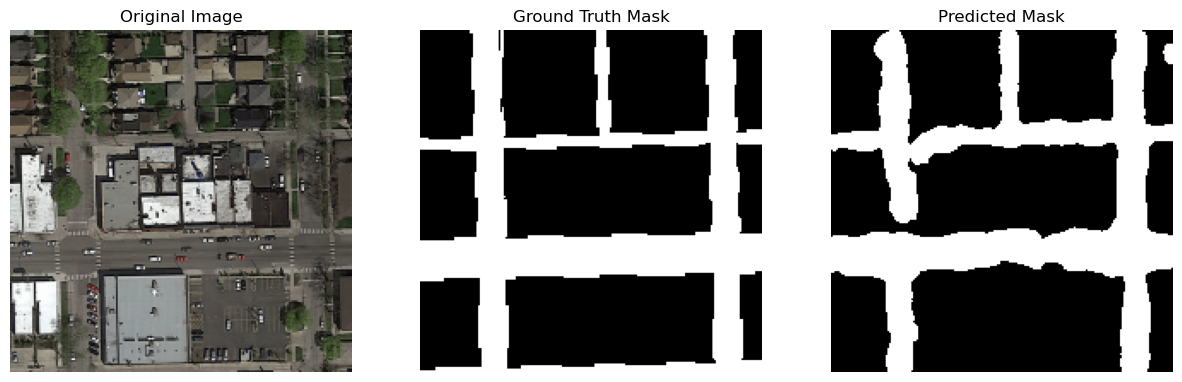

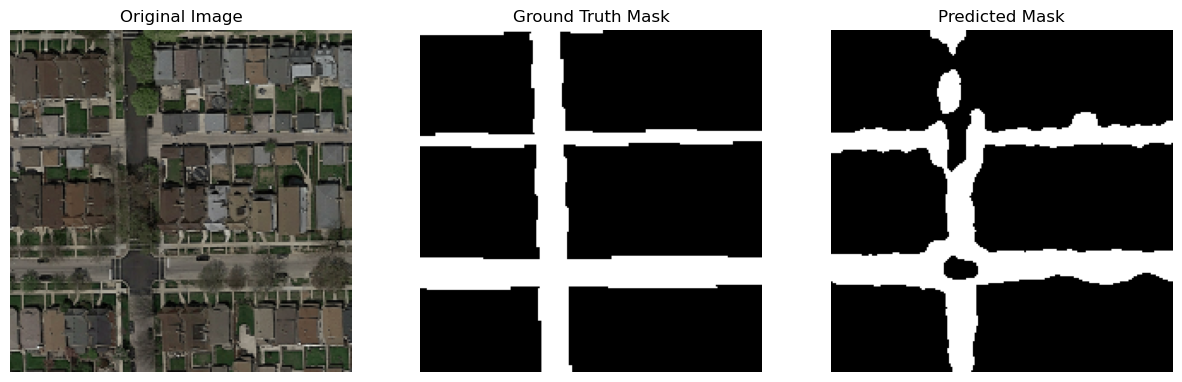

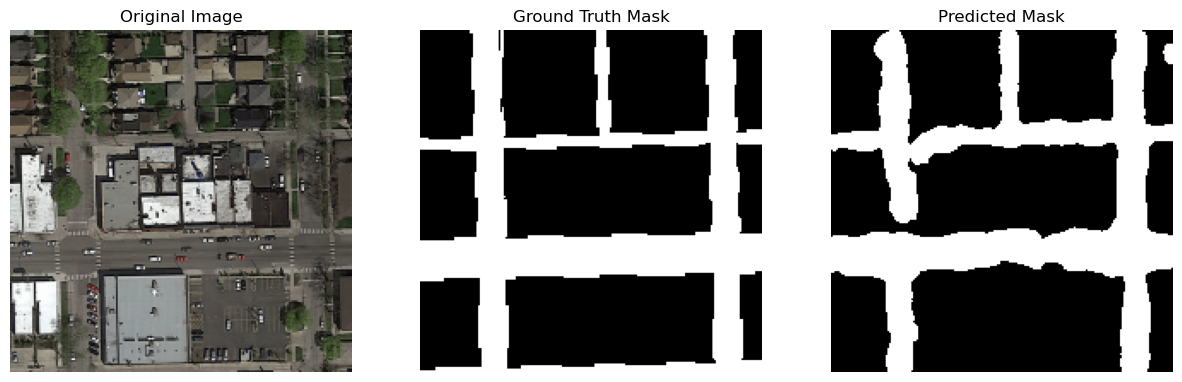

In [34]:
# 9. Visualize Results
# Instantiate the model first
best_model = UNet(in_channels=3, out_channels=1).to(DEVICE)
# Load the saved state dictionary
best_model.load_state_dict(torch.load(best_model_path))

best_model.to(DEVICE)
best_model.eval()

# Helper function for visualization
def visualize_prediction(image, ground_truth_mask, predicted_mask):
    """Plots original image, ground truth, and predicted mask."""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

# Run prediction on a few random validation images
num_visualize = 4
for i in range(num_visualize):
    # Get a random image from the validation set
    idx = random.randint(0, len(valid_dataset) - 1)
    image, gt_mask = valid_dataset[idx]

    # The dataloader gives us a tensor, for visualization we need to
    # process it back to a viewable format.
    original_image = image.permute(1, 2, 0).numpy() # from (C, H, W) to (H, W, C)
    # Undo normalization for viewing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    original_image = std * original_image + mean
    original_image = np.clip(original_image, 0, 1)

    gt_mask = gt_mask.squeeze().numpy() # from (1, H, W) to (H, W)

    # Predict
    with torch.no_grad():
        # Add batch dimension and send to device
        input_tensor = image.unsqueeze(0).to(DEVICE)
        pred_mask = best_model(input_tensor)
        pred_mask = pred_mask.squeeze().cpu().numpy()
        # Apply threshold to get binary mask
        pred_mask = (pred_mask > 0.5).astype(float)

    visualize_prediction(original_image, gt_mask, pred_mask)


In [43]:
# 10. Generate Submission File (Revised and Corrected)
import re
import cv2 # Ensure cv2 is imported

# --- Configuration ---
TEST_IMAGE_DIR = './test_set_images/'
SUBMISSION_FILENAME = 'submission.csv'
PREDICTION_THRESHOLD = 0.25 # Threshold for a patch to be considered "road"

# --- Load the Best Model ---
print("Loading best model for prediction...")
best_model = UNet(in_channels=3, out_channels=1).to(DEVICE)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()
print("Model loaded successfully.")

# --- Helper functions ---
def patch_to_label(patch, threshold):
    """Assigns a label to a patch based on the percentage of road pixels."""
    foreground_percentage = np.mean(patch)
    return 1 if foreground_percentage > threshold else 0

def mask_to_submission_strings(mask_np, image_filename, patch_size=16):
    """
    Generates submission strings from a predicted mask based on the required
    (image_id, x_coordinate, y_coordinate) format.
    """
    img_number = int(re.search(r"(\d+)", image_filename).group(1))
    
    # Iterate over the mask with a 16x16 patch size.
    # j represents the x-coordinate (column index, width)
    # i represents the y-coordinate (row index, height)
    for j in range(0, mask_np.shape[1], patch_size):
        for i in range(0, mask_np.shape[0], patch_size):
            patch = mask_np[i : i + patch_size, j : j + patch_size]
            label = patch_to_label(patch, PREDICTION_THRESHOLD)
            # The required ID format is "image-id_x-coord_y-coord"
            yield ("{:03d}_{}_{},{}".format(img_number, j, i, label))

# --- Main Prediction and Generation Loop ---
test_augmentations = get_validation_augmentations(IMG_SIZE)

# Collect all test image paths
test_image_paths = []
for root, dirs, files in os.walk(TEST_IMAGE_DIR):
    for file in files:
        if file.endswith(".png"):
            test_image_paths.append(os.path.join(root, file))
test_image_paths.sort() # Ensure consistent order

print(f"Found {len(test_image_paths)} test images. Starting prediction...")

with open(SUBMISSION_FILENAME, "w") as f:
    f.write("id,prediction\n")
    for img_path in tqdm(test_image_paths, desc="Generating submission"):
        # Load image to get its original dimensions
        image = cv2.imread(img_path)
        original_height, original_width, _ = image.shape
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transformations for model input (resizes to 400x400)
        augmented = test_augmentations(image=image_rgb)
        input_tensor = augmented['image'].unsqueeze(0).to(DEVICE)

        # Predict with the model
        with torch.no_grad():
            # The model outputs a 400x400 probability mask
            pred_mask_tensor = best_model(input_tensor)
            pred_mask_np_small = pred_mask_tensor.squeeze().cpu().numpy()

        # --- CRITICAL STEP: Resize the predicted mask to the original image size ---
        pred_mask_resized = cv2.resize(
            pred_mask_np_small,
            (original_width, original_height),
            interpolation=cv2.INTER_LINEAR # Use a smooth interpolation for the probability map
        )

        # Generate submission strings from the full-sized mask
        image_filename = os.path.basename(img_path)
        submission_strings = mask_to_submission_strings(pred_mask_resized, image_filename)
        for s_line in submission_strings:
             f.write(f"{s_line}\n")

print(f"--- Submission file '{SUBMISSION_FILENAME}' created successfully! ---")

Loading best model for prediction...
Model loaded successfully.
Found 50 test images. Starting prediction...


Generating submission: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]

--- Submission file 'submission.csv' created successfully! ---


Visualizing predictions for 3 test images...


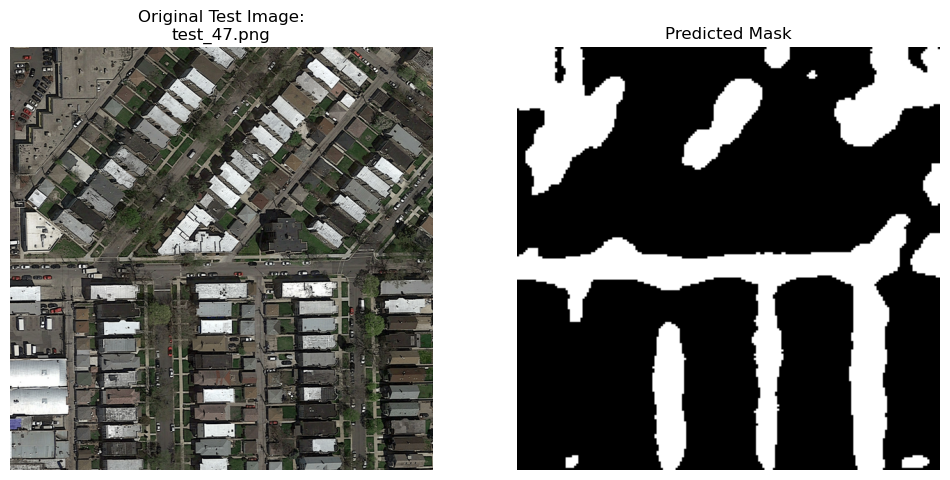

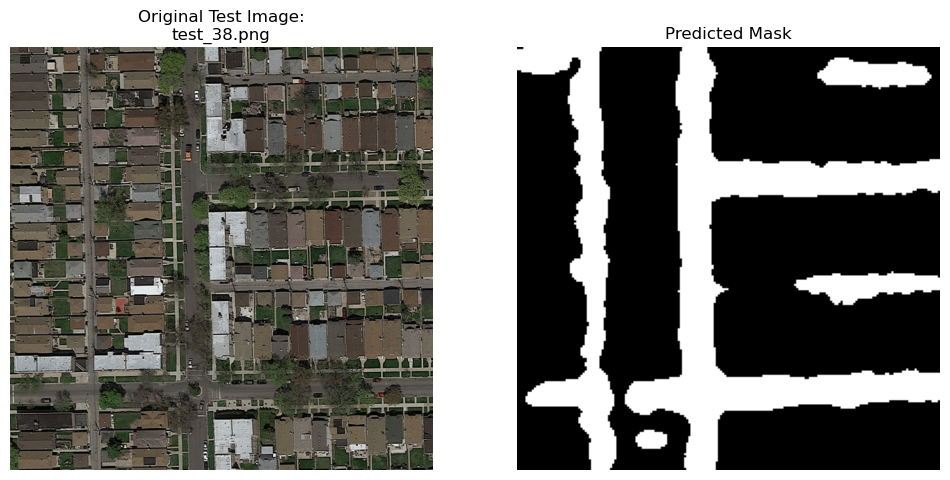

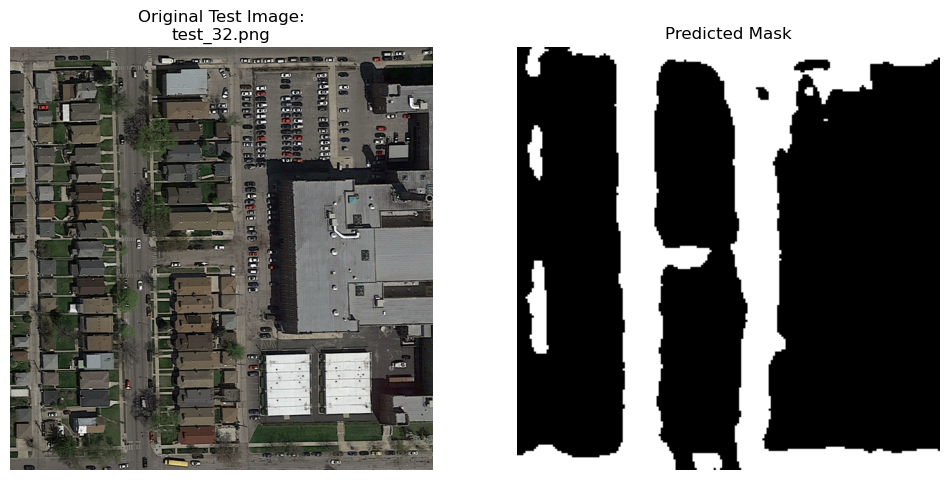

In [33]:
# 11. Visualize Predictions on Test Images

# --- Configuration ---
NUM_IMAGES_TO_VISUALIZE = 3

print(f"Visualizing predictions for {NUM_IMAGES_TO_VISUALIZE} test images...")

# Get a few random image paths from the test set
# Make sure test_image_paths is available from the previous cell
if 'test_image_paths' in locals() and len(test_image_paths) > 0:
    images_to_show = random.sample(test_image_paths, k=min(NUM_IMAGES_TO_VISUALIZE, len(test_image_paths)))
else:
    print("Could not find 'test_image_paths'. Please run the submission generation cell first.")
    images_to_show = []

# Get the augmentations for the test set
test_augmentations_viz = get_validation_augmentations(IMG_SIZE)

for img_path in images_to_show:
    # --- Load and Preprocess Original Image ---
    # Load with OpenCV for processing
    image_bgr = cv2.imread(img_path)
    # Convert to RGB for displaying with Matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    # Apply the same transformations as the test set for prediction
    augmented = test_augmentations_viz(image=image_rgb)
    input_tensor = augmented['image'].unsqueeze(0).to(DEVICE)

    # --- Predict with the Model ---
    with torch.no_grad():
        pred_mask_tensor = best_model(input_tensor)
        # Squeeze to remove batch and channel dims, move to CPU, convert to numpy
        pred_mask_np = pred_mask_tensor.squeeze().cpu().numpy()
        # Apply a 0.5 threshold to get a clear binary mask for visualization
        binary_mask = (pred_mask_np > 0.5).astype(np.uint8)

    # --- Plotting ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(image_rgb)
    ax[0].set_title(f"Original Test Image:\n{os.path.basename(img_path)}")
    ax[0].axis('off')
    
    ax[1].imshow(binary_mask, cmap='gray')
    ax[1].set_title("Predicted Mask")
    ax[1].axis('off')
    
    plt.show()